In [1]:
import pandas as pd 
import geopandas as gpd
import numpy as np 
import seaborn as sns
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from shapely.geometry import Point
import random
import matplotlib.transforms as mtrans

from matplotlib.colors import ListedColormap
from matplotlib import colors


In [2]:
def find_repo_root(start_path):
    current_path = os.path.abspath(start_path)
    
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            current_path = current_path.replace('\\', '/')
            return current_path
        
        parent_path = os.path.dirname(current_path)
        
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
        
        current_path = parent_path

    return None  # Return None if not found

root = find_repo_root(os.getcwd())
root

'c:/Users/fitsl/Documents/Programming/UVM Programming Classes/Data Science I/Project'

In [3]:
def plot_name_cols_geo(visframe_, cmap_, xcol, ycol, ax_, hue_col=None, 
                       cbar_label="Per Capita Flow", drop_cols=None, going=False, verbose=True, tick_changer=None):
    """
    Plot geo-data with "xcol : ycol" on each different shape.

    :param visframe: the geopandas frame to plot from
    :param cmap_: the color map to encode the shapes with (according to ycol)
    :param xcol: the variable to print but not encode
    :param ycol: the variable to print and encode
    :param ax_: the matplotlib axis to put it on. For subplotting in one figure.

    :returns: Nothing. just prints. 

    """
    visframe = visframe_.copy()
    ax_.axis("off")
    if tick_changer:
            visframe[hue_col] = visframe[hue_col].apply(tick_changer)
    visframe.plot(column=hue_col, ax=ax_, cmap=cmap_)
    
    if verbose:
        for geom, x, y in zip(visframe.geometry, visframe[xcol], visframe[ycol]):
            if y is not None:  # Check if the value is not NaN so that we don't try to text untextable things
                point = geom.representative_point()
                if going:            label = f"{x} -> {y}"
                else: label = f"{x} <-  {y}" 
                ax_.text(point.x, point.y, label, fontsize=8, ha='center', color='black')

    if hue_col:
        #Make the range of colros
        norm = mpl.colors.TwoSlopeNorm(vmin=visframe[hue_col].min(), vmax=visframe[hue_col].max(), vcenter=0)
        sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm) 
        cbar = plt.colorbar(sm, ax=ax_)

         
        # Create ticks from min to 0 and from 0 to max
        ticks_min_to_0 = np.linspace(visframe[hue_col].min(), 0, num=5)  # Customize 'num' as needed
        ticks_0_to_max = np.linspace(0, visframe[hue_col].max(), num=5)  # Customize 'num' as needed

        # Combine the two tick ranges
        ticks = np.concatenate([ticks_min_to_0, ticks_0_to_max[1:]])  # Avoid duplicate 0
        ticks = np.sort(ticks)

        #Customize the legend
        cbar.set_label(cbar_label)
        cbar.set_ticks(ticks)  # dynamic ticks
        cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])  


def random_points_in_polygon(polygon, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    
    while len(points) < num_points:
        # Generate a random point within the bounding box
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        
        # Check if the point is inside the polygon
        if polygon.contains(p):
            points.append(p)
    
    return points


In [4]:
def create_point_or_random(row):
    # Check if the lat/long exist
    if pd.notnull(row['Begin Lat']) and pd.notnull(row['Begin Lon']):
        return Point(row['Begin Lon'], row['Begin Lat'])
    else:
        # Get the county polygon geometry (this is assumed to be in 'geometry' column)
        county_geom = row['geometry']  # This is the polygon geometry of the county
        
        # If county geometry exists, generate a random point within the county
        if county_geom and county_geom.is_valid:
            minx, miny, maxx, maxy = county_geom.bounds
            while True:
                # Generate a random point within the bounding box of the county polygon
                random_lon = random.uniform(minx, maxx)
                random_lat = random.uniform(miny, maxy)
                random_point = Point(random_lon, random_lat)
                
                # Check if the point is within the county polygon
                if county_geom.contains(random_point):
                    return random_point
        else:
            return None  # Return None if no valid county geometry exists

In [5]:
## get and clean a big geo frame of all the events

full_events = pd.read_csv(f"{root}/Data/Storm events/Cleaned/full_file.csv")
shapefile_path = f"{root}/Data/Shapefiles/Counties/cb_2023_us_county_500k_MAINLAND.shp"
counties = gpd.read_file(shapefile_path)
counties['STATEFP'] = counties['STATEFP'].astype(int)
counties['COUNTYFP'] = counties['COUNTYFP'].astype(int)
events_geo = counties.merge(
    full_events,
    left_on=['STATEFP', 'COUNTYFP'],  # Columns in the GeoDataFrame
    right_on=['STATE_FIPS', 'COUNTY_FIPS'],) # Columns in the test DataFrame
events_geo.set_crs('EPSG:4326', allow_override=True, inplace=True)
events_geo['point_geometry'] = events_geo.apply(create_point_or_random, axis=1)



C:\Users\fitsl\AppData\Local\Temp\ipykernel_32360\3161800027.py:3: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  full_events = pd.read_csv(f"{root}/Data/Storm events/Cleaned/full_file.csv")


In [6]:
events_geo.iloc[0]

STATEFP                                                                      1
COUNTYFP                                                                     3
COUNTYNS                                                              00161527
GEOIDFQ                                                         0500000US01003
GEOID                                                                    01003
NAME                                                                   Baldwin
NAMELSAD                                                        Baldwin County
STUSPS                                                                      AL
STATE_NAME                                                             Alabama
LSAD                                                                        06
ALAND                                                               4117725048
AWATER                                                              1132887203
geometry                     POLYGON ((-88.02858 30.

In [7]:
full_events.columns

Index(['Unnamed: 0', 'OBJECTID', 'State', 'Month', 'Event Type',
       'Begin Date Time', 'Property Damage', 'Begin Lat', 'Begin Lon',
       'Episode Narrative', 'Event Narrative', 'Lat/Lon Known', 'State FIPS',
       'Year', 'County/Zone FIPS', 'County/Zone Type', 'Event ID',
       'Direct Injuries', 'Indirect Injuries', 'Indirect Deaths',
       'Direct Deaths', 'Episode ID', 'Source', 'Data Source',
       'Tornado F Scale', 'County/Zone Name', 'Total Injuries and Deaths', 'x',
       'y', 'FIPS', 'property_num', 'property_log', 'deaths', 'injuries',
       'deaths_log', 'injury_cat', 'death_cat', 'property_cat', 'STATE_FIPS',
       'COUNTY_FIPS'],
      dtype='object')

In [8]:
state_df = pd.read_csv(f"{root}/Data/State/Cleaned/cleaned_State_to_State_Migrations_Table_2019.csv", )
fips = pd.read_csv(f"{root}/Code/Cleaning/Storm Data Cleaning/fips.csv")
fips['State'] = fips['county']
fips.drop(columns='county', inplace=True)
state_df = state_df.merge(fips, on='State')
state_df['STATE_FIPS'] = state_df['code'].apply(lambda x  : int(x/1000))
state_geo = gpd.read_file(f"{root}/Data/Shapefiles/States_GeoData").merge(
    state_df, left_on='NAME', right_on='State')

visframe = state_geo.to_crs('EPSG:4326')
visframe = visframe[~visframe['State'].isin(['Hawaii', 'Alaska', 'Foreign Country', 'U.S. Island Area', 'Puerto Rico', 'United States2'])]

In [9]:
visframe.columns

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'Unnamed: 0', 'State', 'Alaska',
       'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa',
       'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana',
       'Massachusetts', 'Maryland', 'Maine', 'Michigan', 'Minnesota',
       'Missouri', 'Mississippi', 'Montana', 'North Carolina', 'North Dakota',
       'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico', 'Nevada',
       'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
       'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin',
       'West Virginia', 'Wyoming', 'Foreign Country', 'U.S. Island Area',
       'inflow_max', 'outflow_max', 'inflow_max_noforeign',
       'total_inflow_noforeign', 'total_inflow', 'total_o

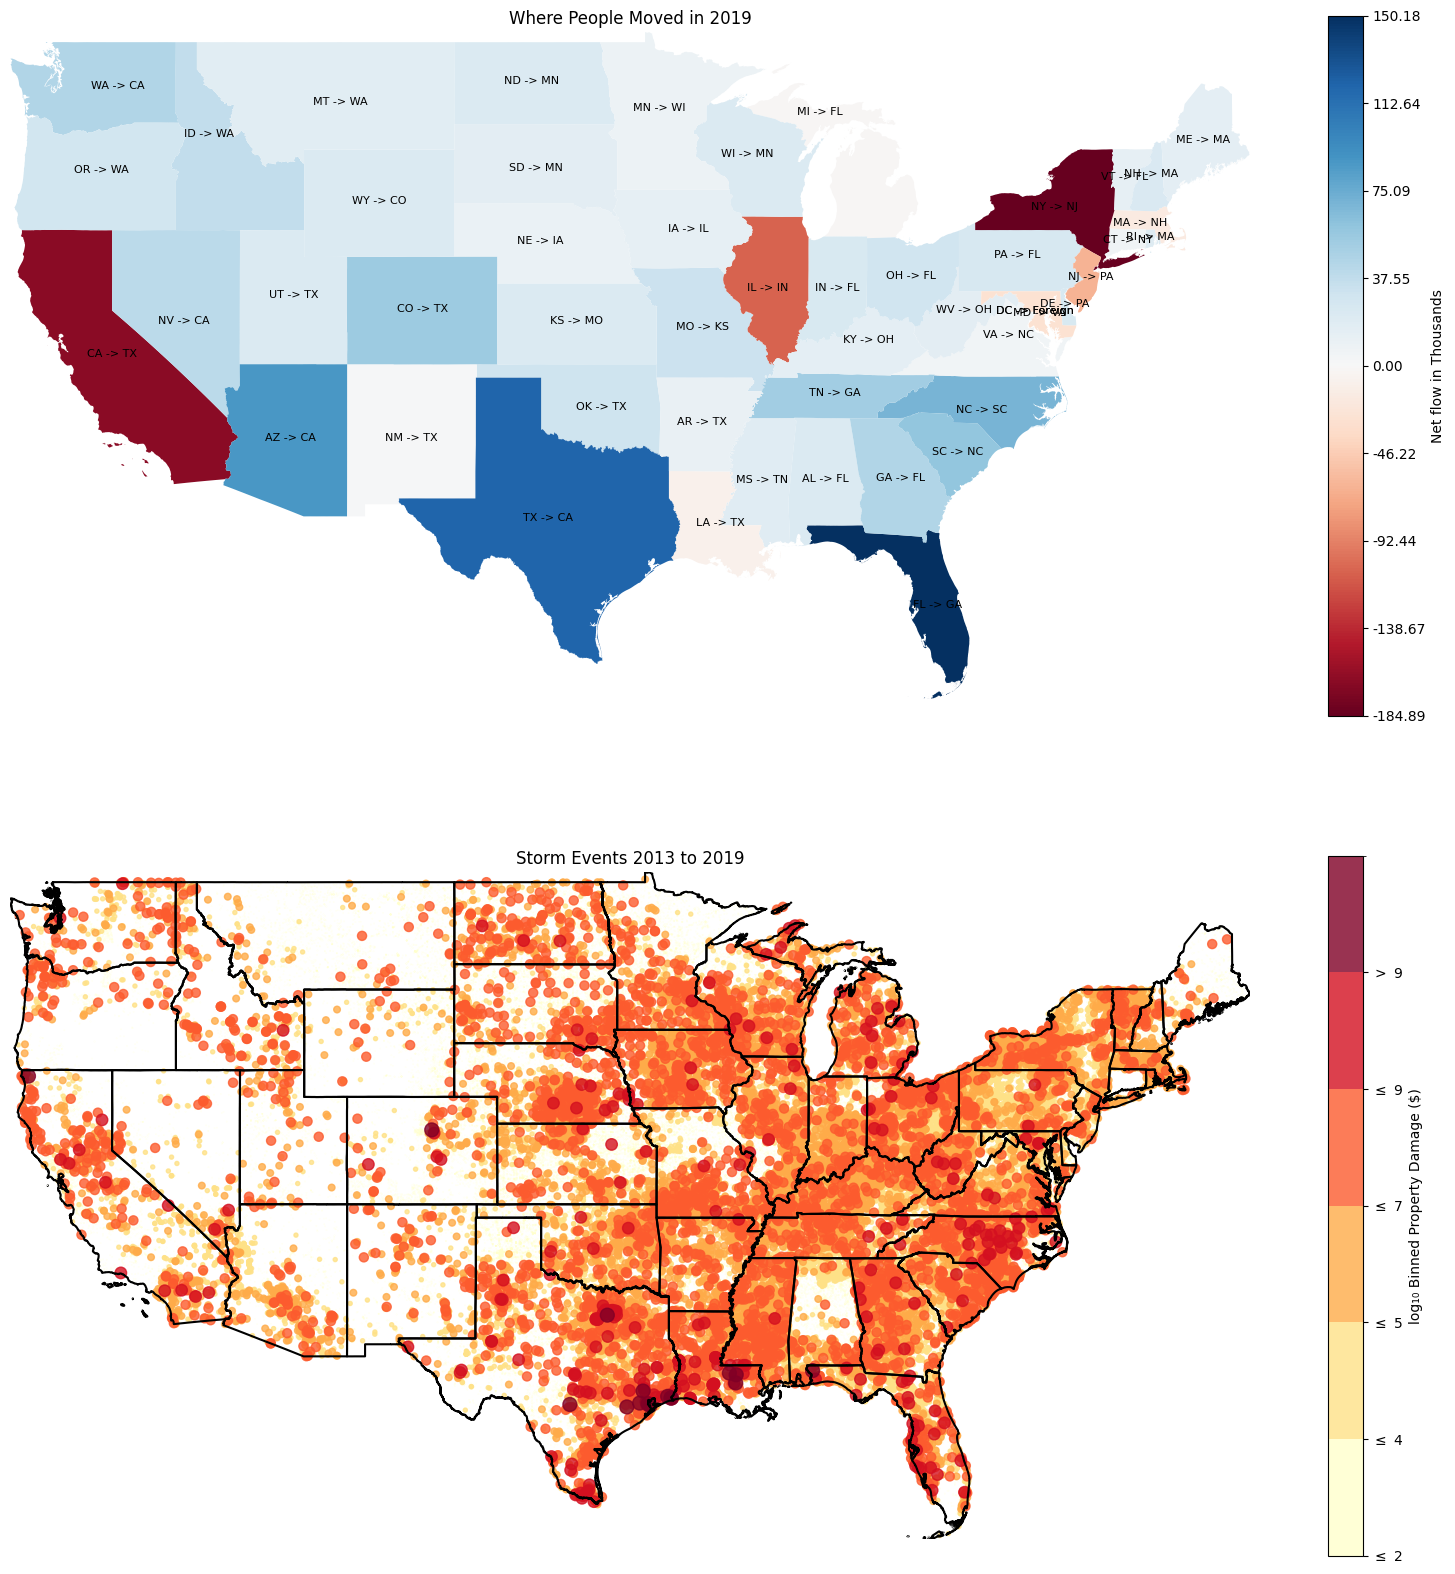

<Figure size 640x480 with 0 Axes>

In [19]:
# Filter and process the GeoDataFrame
gdf = events_geo[events_geo.is_valid].copy()
gdf = gdf.to_crs('EPSG:4326')
x_min, y_min, x_max, y_max = visframe.total_bounds
fig, axes = plt.subplots(2, figsize=(20, 20))

filtered_gdf = gdf[(gdf['Year'] >= 2015) & (gdf['Year'] <= 2019)].copy()
filtered_gdf.sort_values(by='property_cat', inplace=True)

# Plot the first subplot (visframe plot, already done)
plot_name_cols_geo(visframe, 'RdBu', xcol='State_abbr', ycol='outflow_max_abbr', cbar_label="Net flow in Thousands",
                   hue_col='net_flow', ax_=axes[0], tick_changer=lambda x: x / 1000, going=True)

# Normalize property_cat for scatter plot size scaling
scaled_size = np.interp(filtered_gdf['property_cat']**2, (1, 36), (.01, 100))

# Create a discrete colormap based on the unique values in 'property_cat'
category_values = sorted(filtered_gdf['property_cat'].unique())
cmap = plt.get_cmap('YlOrRd', len(category_values))  # Discrete colormap with a number of colors equal to unique categories
norm = colors.BoundaryNorm(boundaries=category_values + [max(category_values) + 1], ncolors=len(category_values)+1)

# Plot boundary and set up the scatter plot for the second subplot
visframe.boundary.plot(ax=axes[1], color='black')
axes[1].axis("off")

scatter1 = axes[1].scatter(filtered_gdf['point_geometry'].x, filtered_gdf['point_geometry'].y,
                           c=filtered_gdf['property_cat'],
                           s=scaled_size,  # Size by normalized 'property_cat'
                           cmap=cmap,
                           norm=norm,
                           alpha=0.8)  # Transparency

# Set the same limits for both plots
for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Create category labels (adjust if necessary based on your dataset)
category_labels = {
    1: r'$\leq$ 2',
    2: r'$\leq$ 4',
    3: r'$\leq$ 5',
    4: r'$\leq$ 7',
    5: r'$\leq$ 9',
    6: r'$>$ 9',
}

# Create a colorbar that corresponds to the categories present in the data
cbar = plt.colorbar(scatter1, ax=axes[1], orientation='vertical')
cbar.set_label("log\u2081\u2080 Binned Property Damage ($)")

# Set the ticks on the colorbar to the unique categories present in the data
cbar.set_ticks(category_values)

# Set the tick labels to the corresponding category labels
cbar.set_ticklabels([category_labels.get(i, str(i)) for i in category_values])

# Set titles for the plots
axes[0].set_title("Where People Moved in 2019")
axes[1].set_title("Storm Events 2013 to 2019")

plt.show()
plt.savefig(f"{root}/Figures/Main/2019_state_to_state_movement_events.png")


In [11]:
category_values

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

In [12]:
minny = filtered_gdf[(filtered_gdf['STATE_FIPS'] == 27 ) &
             (filtered_gdf['property_cat'] > 3)]
minny.sort_values(by='property_cat')

,STATEFP,COUNTYFP,COUNTYNS,GEOIDFQ,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,property_log,deaths,injuries,deaths_log,injury_cat,death_cat,property_cat,STATE_FIPS,COUNTY_FIPS,point_geometry
65091,27,15,00659453,0500000US27015,27015,Brown,Brown County,MN,Minnesota,06,...,5.585461,0,0,0.0,1,1,4,27,15,POINT (-95.0787 44.2273)
64327,27,13,00659452,0500000US27013,27013,Blue Earth,Blue Earth County,MN,Minnesota,06,...,5.176091,0,0,0.0,1,1,4,27,13,POINT (-94.07 44.0923)
64769,27,65,00659478,0500000US27065,27065,Kanabec,Kanabec County,MN,Minnesota,06,...,5.397940,0,0,0.0,1,1,4,27,65,POINT (-93.4575 45.8995)
63909,27,97,00659494,0500000US27097,27097,Morrison,Morrison County,MN,Minnesota,06,...,5.685742,0,0,0.0,1,1,4,27,97,POINT (-93.76877 45.96334)
63850,27,97,00659494,0500000US27097,27097,Morrison,Morrison County,MN,Minnesota,06,...,6.000000,0,0,0.0,1,1,4,27,97,POINT (-94.4521 46.0618)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881371,27,37,00659464,0500000US27037,27037,Dakota,Dakota County,MN,Minnesota,06,...,5.397940,0,0,0.0,1,1,4,27,37,POINT (-93.1418 44.7237)
881430,27,37,00659464,0500000US27037,27037,Dakota,Dakota County,MN,Minnesota,06,...,6.954243,0,0,0.0,1,1,4,27,37,POINT (-93.19648 44.73245)
883994,27,123,00659507,0500000US27123,27123,Ramsey,Ramsey County,MN,Minnesota,06,...,5.698970,0,0,0.0,1,1,4,27,123,POINT (-93.1152 45.0988)
981525,27,87,00659488,0500000US27087,27087,Mahnomen,Mahnomen County,MN,Minnesota,06,...,5.755875,0,0,0.0,1,1,4,27,87,POINT (-95.68606 47.2039)


In [13]:
data_file_path = f"{root}/Data/County/Summed_clean/summed_2016_2020.csv"
dfs_dict = pd.read_csv(data_file_path)

dfs_dict['in_gross_thousands'] = dfs_dict['Inflow_gross'] / 1000
dfs_dict['out_gross_thousands'] = dfs_dict['Outflow_gross'] / 1000
dfs_dict['net_thousands'] = dfs_dict['in_gross_thousands'] - dfs_dict['out_gross_thousands']
dfs_dict['Net_pc'] = ((dfs_dict['net_thousands'] * 1000) / dfs_dict['Population']) * 100
shapefile_path = f"{root}/Data/Shapefiles/Counties/cb_2023_us_county_500k_MAINLAND.shp"

counties = gpd.read_file(shapefile_path)
counties['STATEFP'] = counties['STATEFP'].astype(int)
counties['COUNTYFP'] = counties['COUNTYFP'].astype(int)

merged_gdf = counties.merge(
    dfs_dict,
    left_on=['STATEFP', 'COUNTYFP'],  # Columns in the GeoDataFrame
    right_on=['STATE_FIPS', 'COUNTY_FIPS'],  # Columns in the test DataFrame
    how='left'  # Change this to 'outer', 'left', or 'right' if needed
)

In [14]:
state_fips = pd.read_csv(f"{root}/Code/Cleaning/Storm Data Cleaning/fips.csv", dtype={'code': str},)
state_fips['code'] = state_fips['code'].apply(lambda x: int((str(x)[0:2])))
state_fips.drop_duplicates(subset='code', keep='first')

,code,county
0,1,Alabama
68,2,Alaska
97,4,Arizona
113,5,Arkansas
189,6,California
248,8,Colorado
312,9,Connecticut
321,10,Delaware
325,11,District of Columbia
327,12,Florida


In [15]:
break 

SyntaxError: 'break' outside loop (371449011.py, line 1)

In [ ]:


# Define a function to plot each state
def plot_state(gdf_state, ax, state_name, merged_gdf_, boundary=None, scatter=True, savepath=None):

    # Filter data for the years and property category conditions
    filtered_gdf = gdf_state[(gdf_state['Year'] <= 2019)].copy()
    if state_name:
        merged_gdf = merged_gdf_[merged_gdf_['STATE_FIPS'] == filtered_gdf['State FIPS'].iloc[0]].copy()
    else:
        state_name="United States"
        merged_gdf = merged_gdf_.copy()
    
    
    gdf_state = gdf_state.to_crs(epsg=4326) 
    x_min, y_min, x_max, y_max = gdf_state.geometry.total_bounds

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('auto')
    
    
    # Plot boundary and scatter plot

    if boundary:
        gdf_state.boundary.plot(ax=ax, color='black')
        counties = None
    else:
        norm = mpl.colors.TwoSlopeNorm(vmin=-5, vmax=25, vcenter=0) ## min max for all of them, roughly
        merged_gdf = merged_gdf.to_crs(gdf_state.crs)
        counties = merged_gdf.plot(column='net_thousands',  # Choose the appropriate column to plot
                            cmap='RdBu',  # Change this to a diverging colormap
                            legend=True,
                        norm=norm,                     
                            missing_kwds={'color': 'lightgrey', 'label': 'Missing Values'},
                            edgecolor='none', 
                            legend_kwds={'label': "Net Migration in Thousands"},
                            ax=ax,)  
    ax.axis("off")  # Remove axis for clarity

    if scatter:
        # Normalize the 'property_cat' values to determine the size of the scatter plot points
        scaled_size = np.interp(filtered_gdf['property_cat']**2, (1, 36), (.001, 20))
        filtered_gdf.sort_values(by='property_cat', inplace=True) #this makes sure it goes in the right order later

        # Create a discrete colormap based on the unique values in 'property_cat'
        category_values = [1, 2, 3, 4, 5, 6, 9]
        cmap = plt.get_cmap('viridis', len(category_values))   # Discrete colormap with a number of colors equal to unique categories
        norm = colors.BoundaryNorm(boundaries= category_values, ncolors=6)

        scatter1 = ax.scatter(filtered_gdf['point_geometry'].x, filtered_gdf['point_geometry'].y,
                            c=filtered_gdf['property_cat'], s=scaled_size, cmap=cmap, norm=norm,
                            alpha=0.7)
        
        # Set the title for each subplot
        ax.set_title(f"Migration in {state_name} 2015-2019 with Storm Events")

        # Set up colorbar for each plot
        category_labels = {
        1: r'$\leq$ 2',
        2: r'$\leq$ 4',
        3: r'$\leq$ 5',
        4: r'$\leq$ 7',
        5: r'$\leq$ 9',
        6: r'$>$ 9',
    }
        category_values = [1, 2, 3, 4, 5, 6]
        cbar = plt.colorbar(scatter1, ax=ax, orientation='vertical')
        cbar.set_label("log\u2081\u2080 Categorized Property Damage ($)")
        cbar.set_ticks(category_values)
        cbar.set_ticklabels([category_labels.get(i, str(i)) for i in range(1, len(category_values)+1)])
    else: scatter1 = None

    return (scatter1, counties)



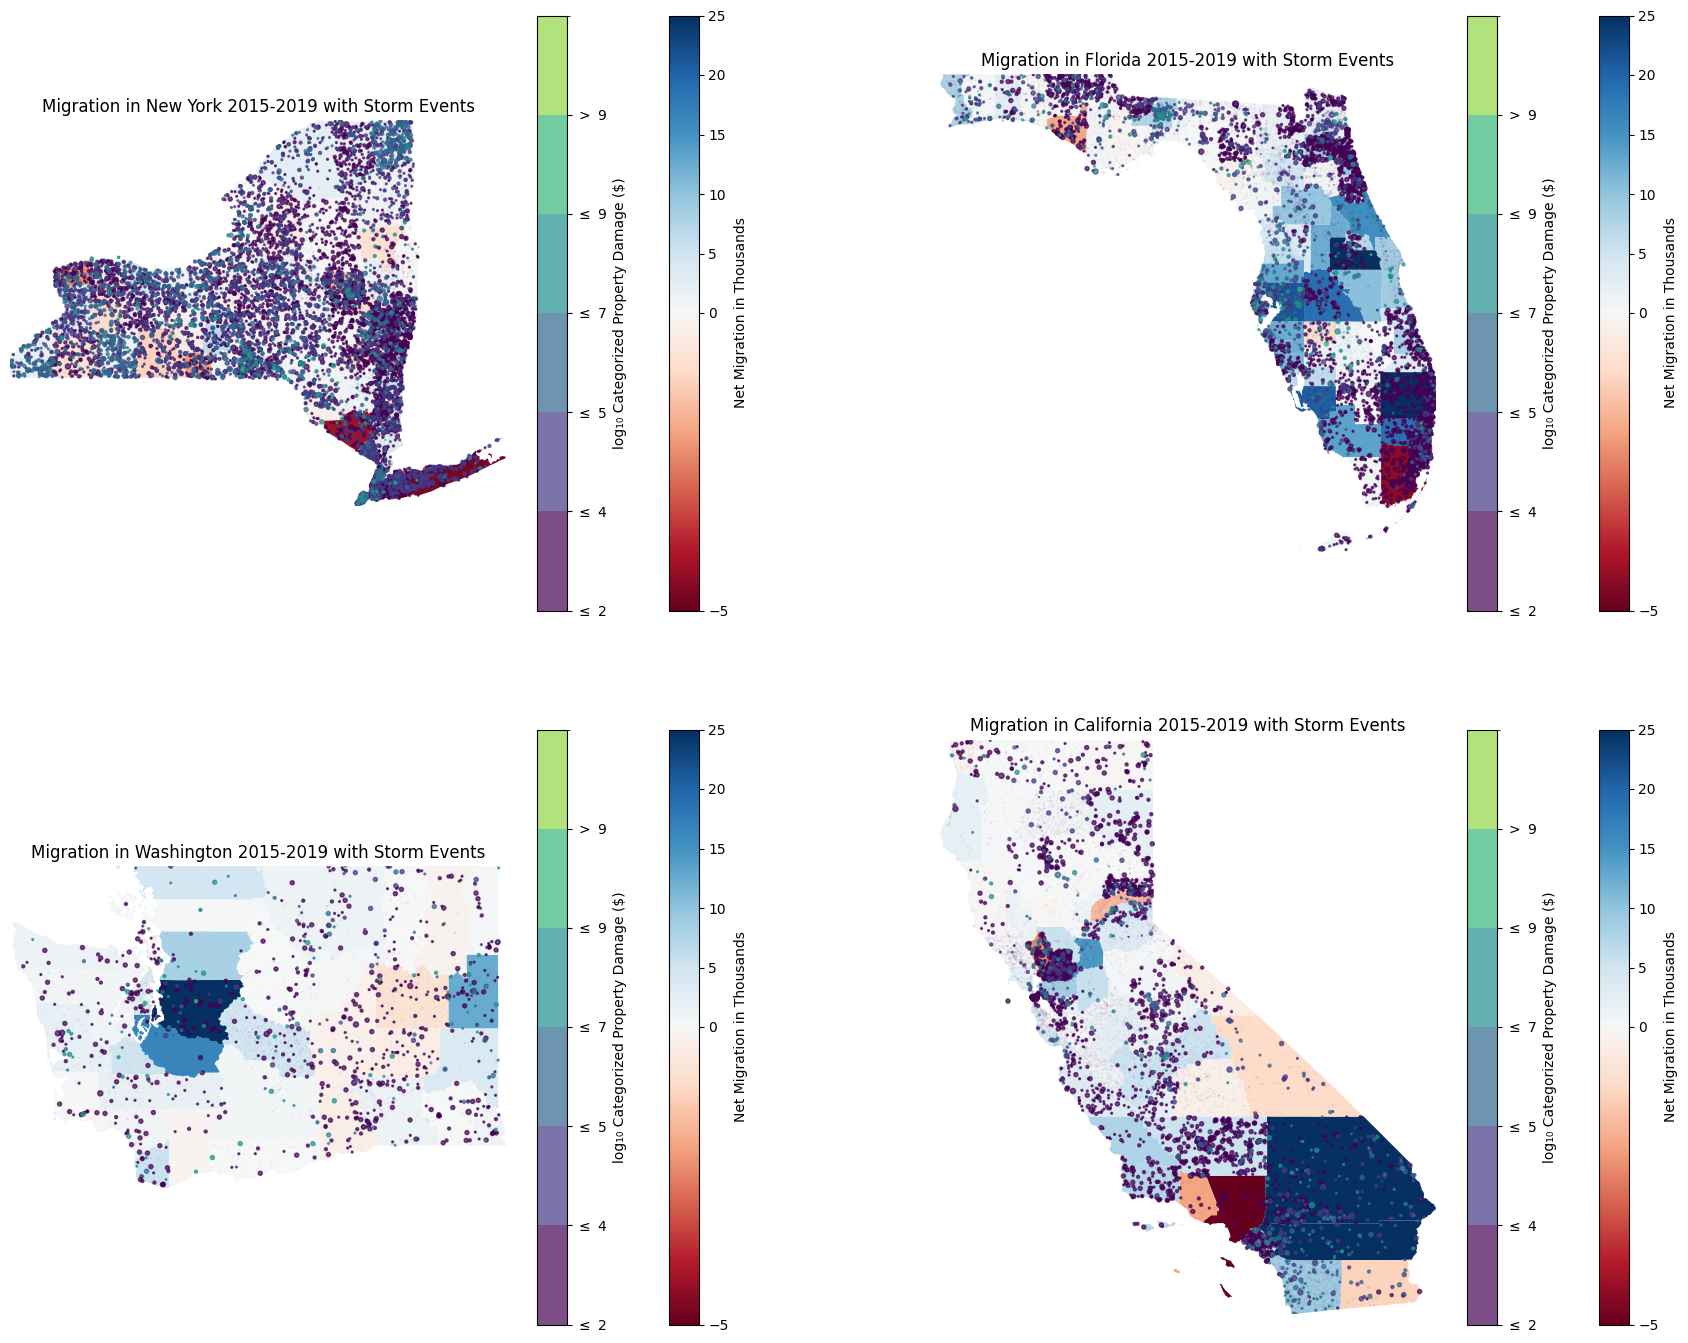

In [18]:
# Define FIPS codes for the states we are interested in
state_fips = {
    'NY': 36,   # New York
    'FL': 12,   # Florida
    'WA': 53,   # Washington
    'CA': 6     # California
}

# # Uncomment the first time you run ##

# Filter the data for each state
gdf = events_geo.copy()
# gdf = gdf.to_crs('EPSG:4326')
gdf_ny = gdf[gdf['STATE_FIPS'] == state_fips['NY']].copy()
gdf_fl = gdf[gdf['STATE_FIPS'] == state_fips['FL']].copy()
gdf_tx = gdf[gdf['STATE_FIPS'] == state_fips['WA']].copy()
gdf_ca = gdf[gdf['STATE_FIPS'] == state_fips['CA']].copy()

# Set up a 2x2 grid for the subplots
fig, axes = plt.subplots(2, 2, figsize=(22, 17))


    
# Plot each state
scatter1 = plot_state(gdf_ny, axes[0, 0], "New York", merged_gdf)[0]
colors_ = plot_state(gdf_fl, axes[0, 1], "Florida", merged_gdf)[1]
plot_state(gdf_tx, axes[1, 0], "Washington", merged_gdf)
plot_state(gdf_ca, axes[1, 1], "California", merged_gdf)
plt.savefig(f"{root}/Figures/Main/four_state_county_migration_plots.png")
plt.show()

In [ ]:
# merged_gdf['property_cat'] = merged_gdf['property_cat'].astype(int)
gdf['property_cat'].value_counts()
# Filter the data for each state 
fig, (ax1, ax2) =plt.subplots(2, figsize=(20,20))
plot_state(gdf, ax1, "", merged_gdf, scatter=False)
plot_state(gdf, ax2, "", merged_gdf, boundary=True)
plt.show()
plt.savefig(f"{root}/Figures/Main/big_plot_all_counties_all_events")

RuntimeError: python error has been set

: 

: 

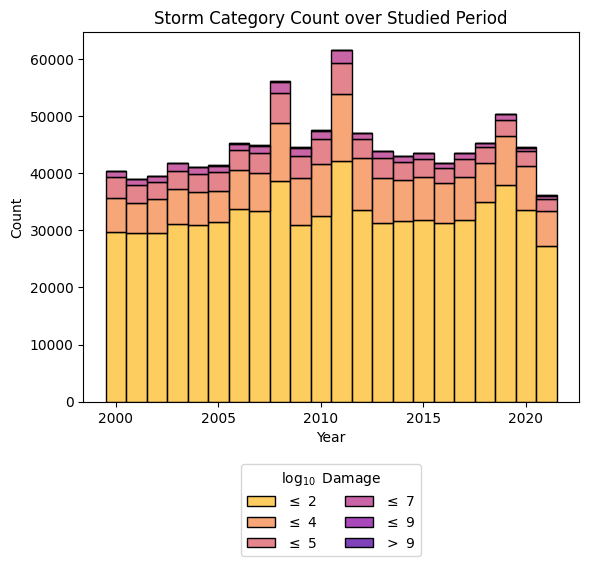

In [22]:
# Ensure 'property_cat' is treated as categorical
events_geo_ = events_geo.copy()
events_geo_['property_cat'] = events_geo_['property_cat'].astype('category')


category_labels = {
    1: r'$\leq$ 2',
    2: r'$\leq$ 4',
    3: r'$\leq$ 5',
    4: r'$\leq$ 7',
    5: r'$\leq$ 9',
    6: r'$>$ 9',
}

hue_order = [6, 5, 4, 3, 2, 1]

labels = [category_labels[i+1]for i in range(len(category_labels))]

# Create the histogram with the custom discrete palette
sns.histplot(data=events_geo_, x='Year', hue='property_cat', palette='plasma', multiple="stack", discrete=True, hue_order=hue_order)
plt.legend(title=r"$\log_{10}$ Damage", labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
# Show the plot
plt.title("Storm Category Count over Studied Period")
plt.savefig(f"{root}/Figures/Main/Storm_event_property_damage_over_studied_period")
plt.show()